<h2>Explaining classifications of Fashion-MNIST images.</h2>

Fashion-MNIST from Zalando Research (https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion) has been proposed as a replacement dataset to the near-ubiquitous MNIST dataset. 

Let's roll with that and see if and how LIME can explain predictions made on this dataset. We'll use a relatively straightforward convolutional neural network in Keras. This code is heavily based on https://gist.github.com/kashif/76792939dd6f473b7404474989cb62a8.

In [2]:
import numpy as np
from mnist import MNIST
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
from random import random
import math
%matplotlib inline  

from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

Read and prepare data.

In [3]:
batch_size = 128
num_classes = 10
epochs = 30

# input image dimensions                                                                                                                                                                 
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets                                                                                                                               
mndata = MNIST(path='data/fashion', )
x_train, y_train = mndata.load_training()
x_test, y_test = mndata.load_testing()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

Plot some examples.

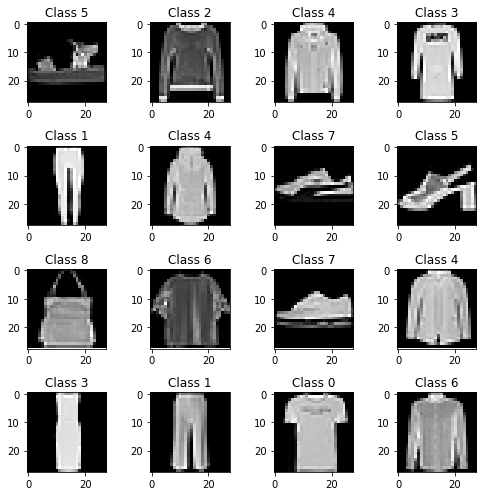

In [4]:
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
for i in range(16):
    plt.subplot(4,4,i+1)
    ix = math.floor(random()*len(x_train))
    plt.imshow(x_train[ix].reshape(28,28), cmap='gray')
    plt.title("Class {}".format(y_train[ix]))  #(np.argmax(y_train[ix])))
plt.tight_layout()

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 3)

LIME requires color images to work, so we have to convert our grey-scale images to a kind of pseudo-color.

In [6]:
x_train = np.stack([gray2rgb(iimg) for iimg in x_train])
x_test = np.stack([gray2rgb(iimg) for iimg in x_test])

Now we can reshape the image data to (no. of images x width x height x color channels), scale intensities to [0..1] and convert the class vectors to one-hot encoded categorical variables.

In [7]:
x_train = x_train.reshape([-1,28,28,3])
x_test = x_test.reshape([-1,28,28,3])
print(x_train.shape)
print(x_test.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# convert class vectors to binary class matrices                                                                                                                                         
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(60000, 28, 28, 3)
(10000, 28, 28, 3)
x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


Define and run a "default" Keras model.

In [117]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 123s - loss: 0.4655 - acc: 0.8370 - val_loss: 0.3082 - val_acc: 0.8879
Epoch 2/30
60000/60000 [==============================] - 123s - loss: 0.3069 - acc: 0.8881 - val_loss: 0.2529 - val_acc: 0.9047
Epoch 3/30
60000/60000 [==============================] - 122s - loss: 0.2604 - acc: 0.9053 - val_loss: 0.2255 - val_acc: 0.9162
Epoch 4/30
60000/60000 [==============================] - 116s - loss: 0.2332 - acc: 0.9143 - val_loss: 0.2135 - val_acc: 0.9208
Epoch 5/30
60000/60000 [==============================] - 120s - loss: 0.2098 - acc: 0.9227 - val_loss: 0.2091 - val_acc: 0.9261
Epoch 6/30
60000/60000 [==============================] - 120s - loss: 0.1902 - acc: 0.9293 - val_loss: 0.2031 - val_acc: 0.9266
Epoch 7/30
60000/60000 [==============================] - 120s - loss: 0.1753 - acc: 0.9330 - val_loss: 0.2046 - val_acc: 0.9285
Epoch 8/30
60000/60000 [=======================

In [8]:
#model.save("model.h5")
model = load_model("model_fashion.h5")

/Users/mikaelhuss/anaconda3/lib/python3.6/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Get predictions for the test set.

In [9]:
preds = model.predict(x_test)

Import the LIME stuff.

In [10]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

Look at some cases that the model got wrong.

In [11]:
np.random.seed(seed=102)
pred_cat = np.array([np.argmax(vec) for vec in preds])
y_test_cat = np.array([np.argmax(vec) for vec in y_test])
wrong_idx = np.random.choice(np.where(pred_cat != y_test_cat)[0])

print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test_cat[wrong_idx], pred_cat[wrong_idx]))

Using #3912 where the label was 4 and the pipeline predicted 2


In [13]:
%%time
explanation = explainer.explain_instance(x_test[wrong_idx], 
                                         classifier_fn = model.predict, 
                                         top_labels=6, hide_color=0, num_samples=10000, qs_kernel_size = 1)

CPU times: user 28.6 s, sys: 784 ms, total: 29.3 s
Wall time: 7.15 s


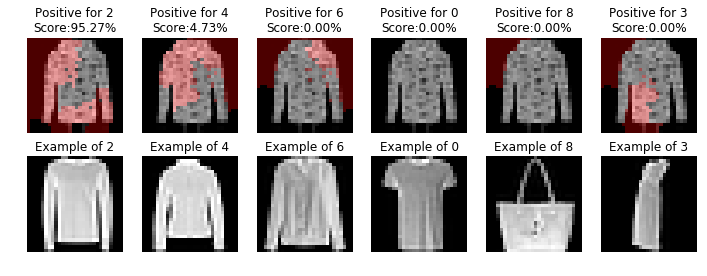

In [14]:
fig, m_axs = plt.subplots(2,6, figsize = (12,4))
for i, (c_ax, gt_ax) in zip(explanation.top_labels, m_axs.T):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=5, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i, 100*preds[wrong_idx, i]))
    c_ax.axis('off')
    img_id = np.random.choice(np.where(y_test_cat==i)[0])
    gt_ax.imshow(x_test[img_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')